In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.join("./", "..", ".."))

In [2]:
config_path = './../../configs/vae.json'
import json
from types import SimpleNamespace
config = SimpleNamespace(**json.load(open(config_path, 'r')))

In [3]:
feature_names = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

# def f(x):
#     if x == 'M':
#         return 1
#     else:
#         return 0
# y = pd.read_csv('./../../Data/breast/breast.csv', usecols = ['diagnosis'])['diagnosis'].apply(f).to_numpy()

# X = X - np.min(X, axis = 0)
# X = X / np.max(X, axis = 0)


# np.savetxt("./../../Data/breast/X.tsv", X, delimiter="\t")
# np.savetxt("./../../Data/breast/y.tsv", y, delimiter="\t")

In [4]:
config

namespace(features_path='./Reproduction/Housing/Data/X.tsv',
          labels_path='./Reproduction/Housing/Data/y.tsv',
          model_dir='./Models/',
          batch_size=128,
          min_epochs=200,
          stopping_epochs=25,
          tol=0.001,
          eval_freq=1,
          lr=0.001)

In [5]:
config.features_path = "./../../Data/breast/X.tsv"
config.labels_path = "./../../Data/breast/y.tsv"
config.model_dir = './../../Models'
config.dataset = "breast"
config.lr = 0.005

In [6]:
from Model import *
train_model = False
if train_model:
    model = Model.Initialize('vae', None, pretrained_path=None, config=config)
else:
    model = Model.Initialize('vae', None, pretrained_path='./../../Models/scvis_breast.pt', config=config)

Loading the pretrained model...


In [7]:
x = pd.read_csv('./../../Data/breast/X.tsv', sep="\t").to_numpy()
data_rep = model.Encode(x)

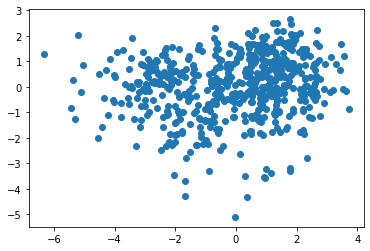

In [8]:
plt.scatter(data_rep[:,0], data_rep[:,1])
plt.show()

In [9]:
from sklearn.cluster import KMeans
num_clusters = 3

kmeans = KMeans(n_clusters = num_clusters, random_state=0).fit(data_rep)

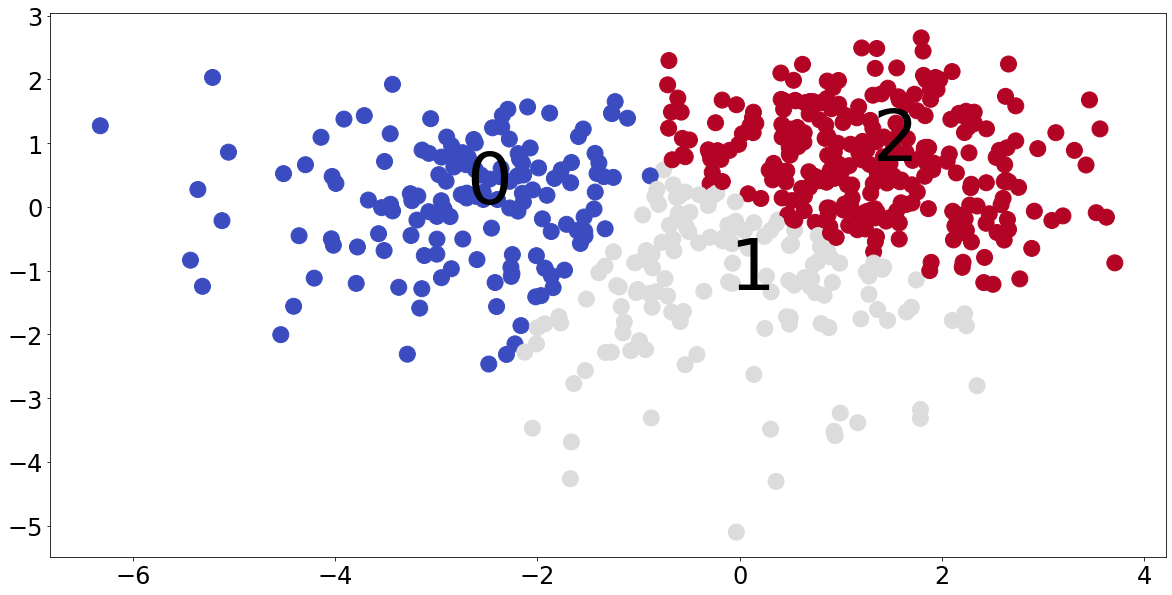

In [10]:
from eldr.plotter.myplot import *
means, centers, indices = plot_groups(x, data_rep.numpy(), num_clusters, kmeans.labels_, name = "./synth-rep.png")

In [11]:
from eldr.explain.explain_cs import *
epsilon = 0

Explainer = Explain(model, means, centers, use_scaling=False)

epsilons = np.linspace(0, 2.0, num=100).tolist()
for iter_epsilon in epsilons:
    mean_, min_, max_ = Explainer.eval_epsilon(torch.tensor(x), indices, iter_epsilon)
    if mean_ >= 0.95 and min_ >= 0.95 and max_>= 0.95:
        epsilon = iter_epsilon
        break
print(epsilon)

0.4646464646464647


[[-0.5483335  -0.00162154 -0.01315631 -0.20158997  0.00153071 -0.00047825
  -0.00127417 -0.00063251 -0.00147978 -0.00134502 -0.00048278  0.00096343
  -0.00011317 -0.0099388  -0.00001238 -0.00154859 -0.00059203  0.00133072
  -0.00002716 -0.00060528 -0.00927129  0.00023296 -0.02366703 -1.0528208
   0.00018228 -0.0011055  -0.00183528 -0.00175578 -0.00068142  0.00101965]
 [-0.53558654 -0.00036915 -0.01121742 -0.19193488  0.00008578 -0.6334926
  -0.01995801 -0.18897836  0.00002676 -0.00568068 -0.00081108  0.00084404
   0.00016906 -0.00967276  0.0008016  -0.47072032 -0.00181708 -0.00033372
   0.00036841  0.00048306 -0.00825065  0.00007661 -0.02052527 -1.1384377
  -0.00724439 -0.0057729  -0.00129461 -0.11347555 -0.00132555  0.00039219]]


./../../eldr/plotter/myplot.py:106: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/home2/tirthankar/miniconda3_1/envs/rajeev3/lib/python3.7/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


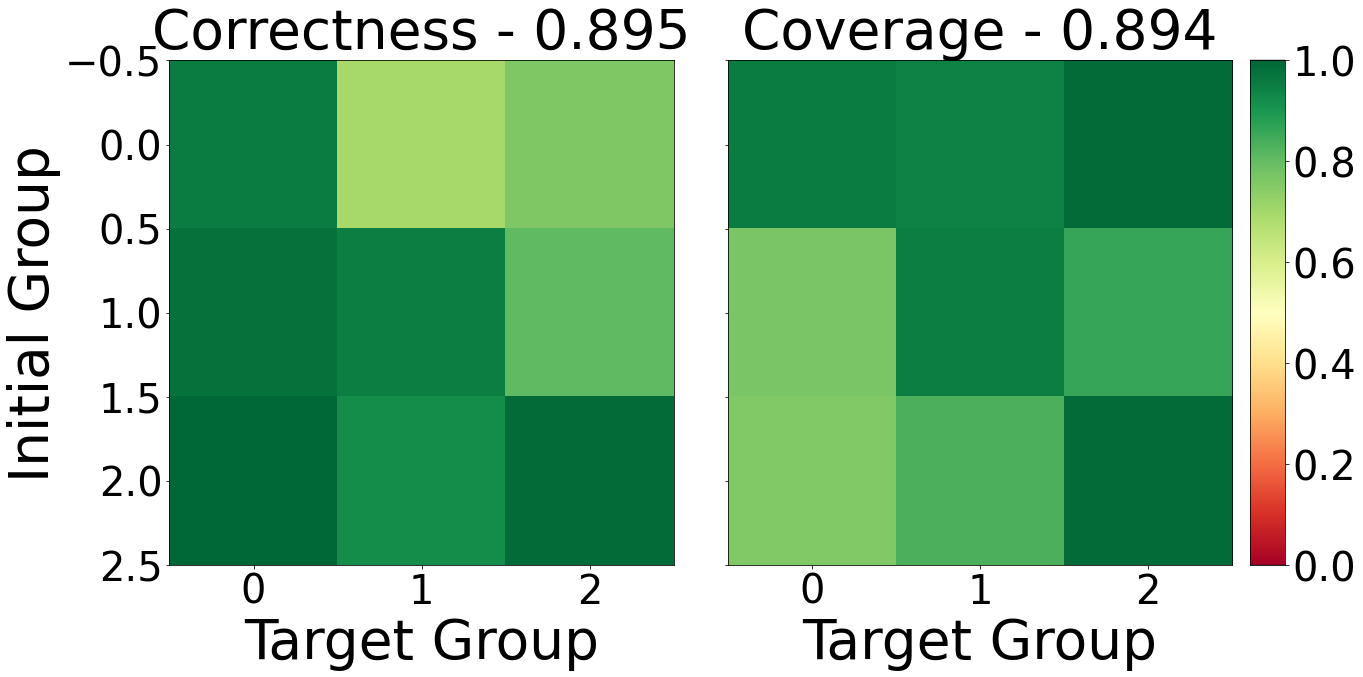

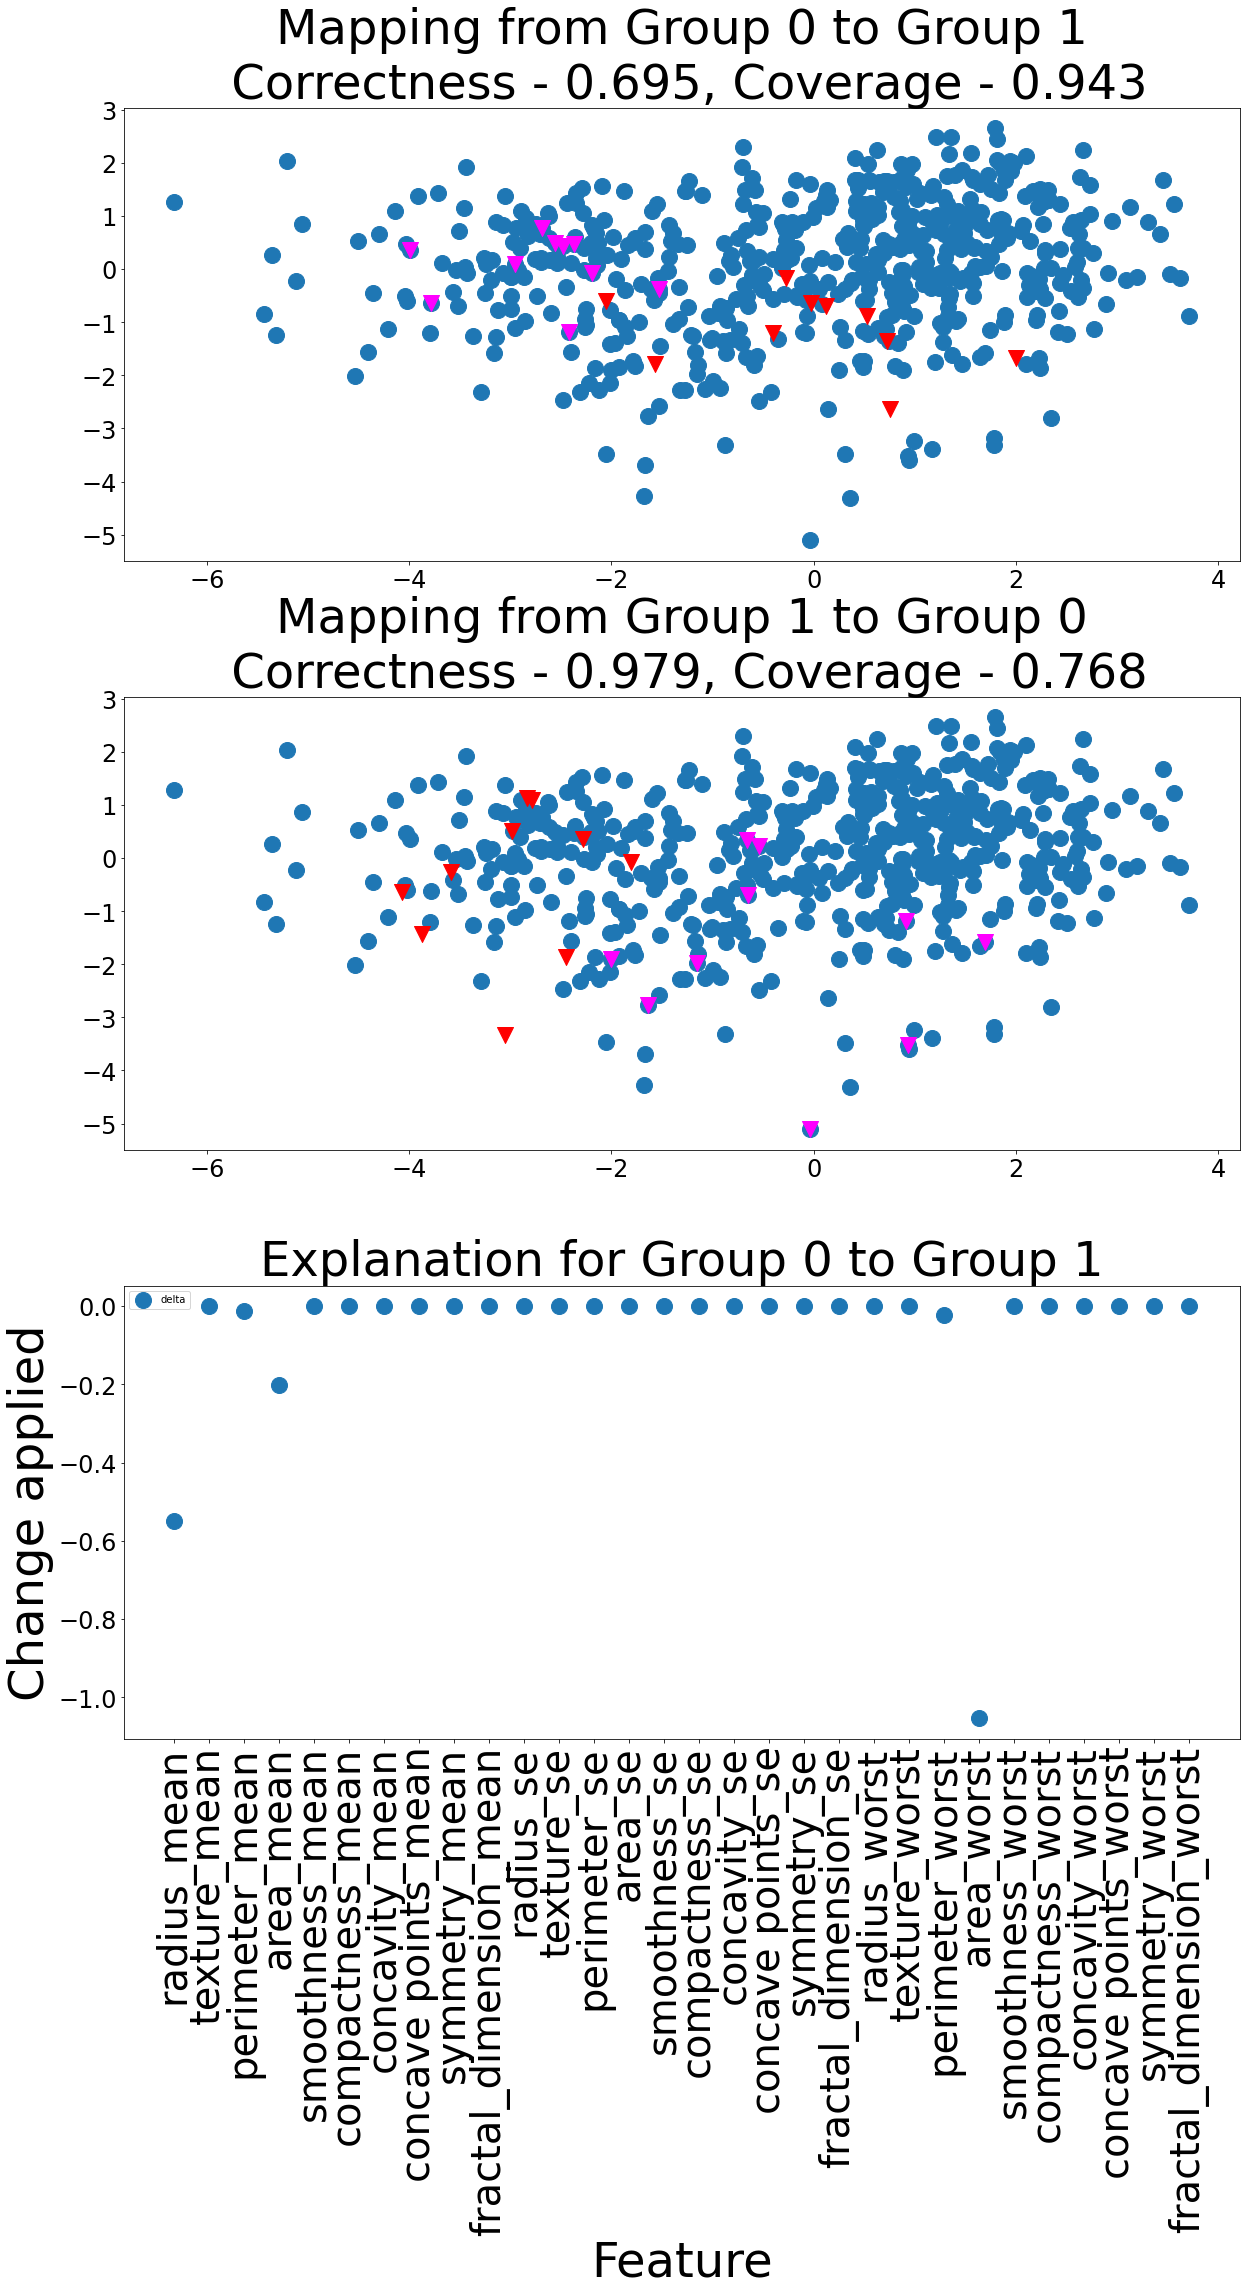

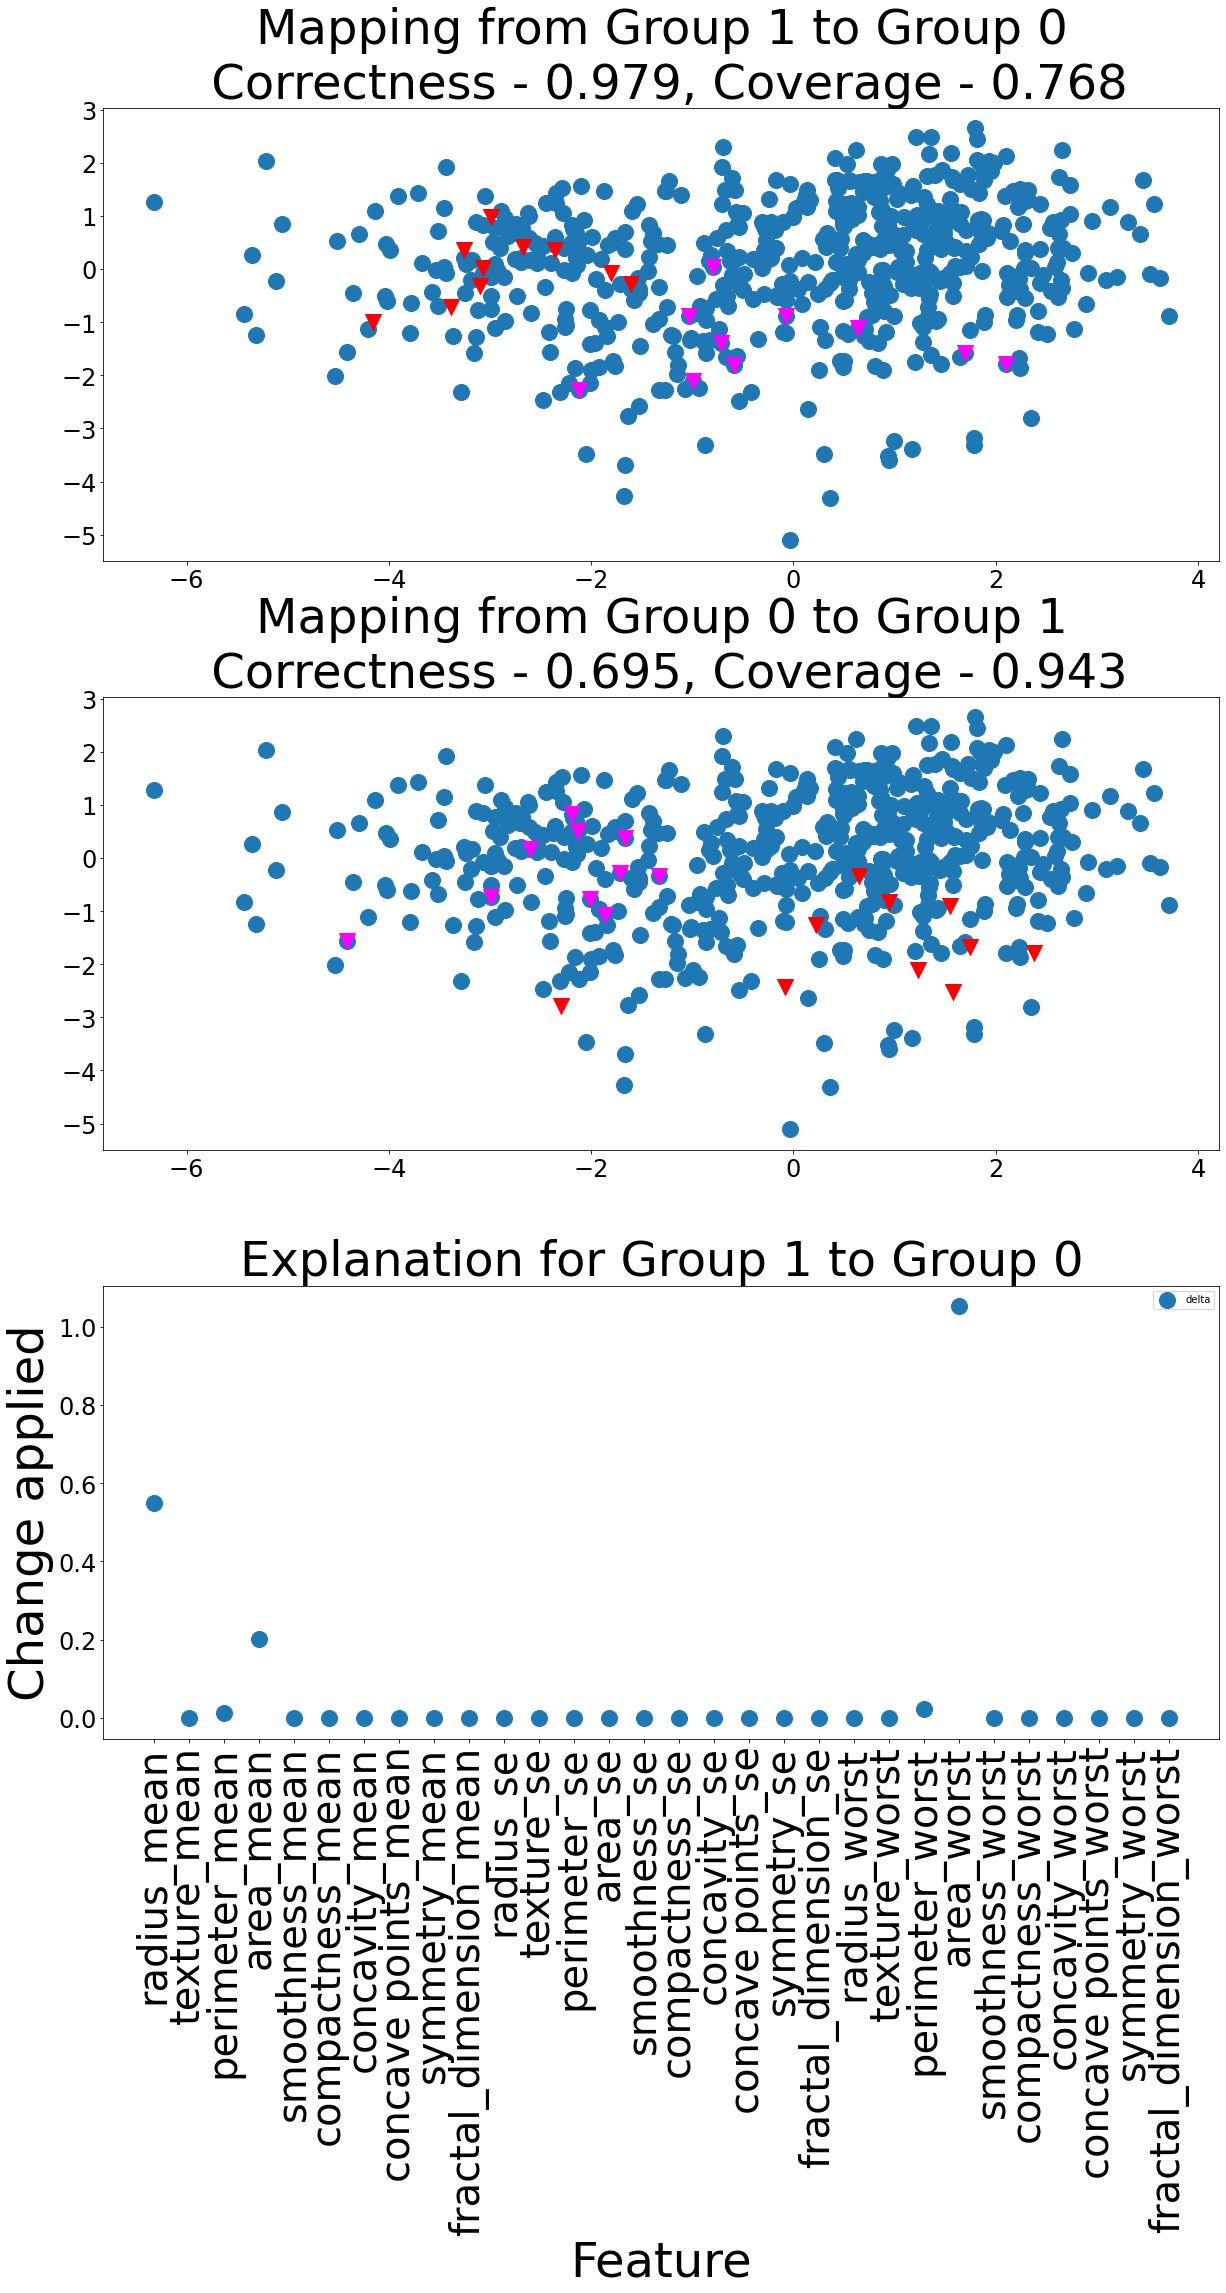

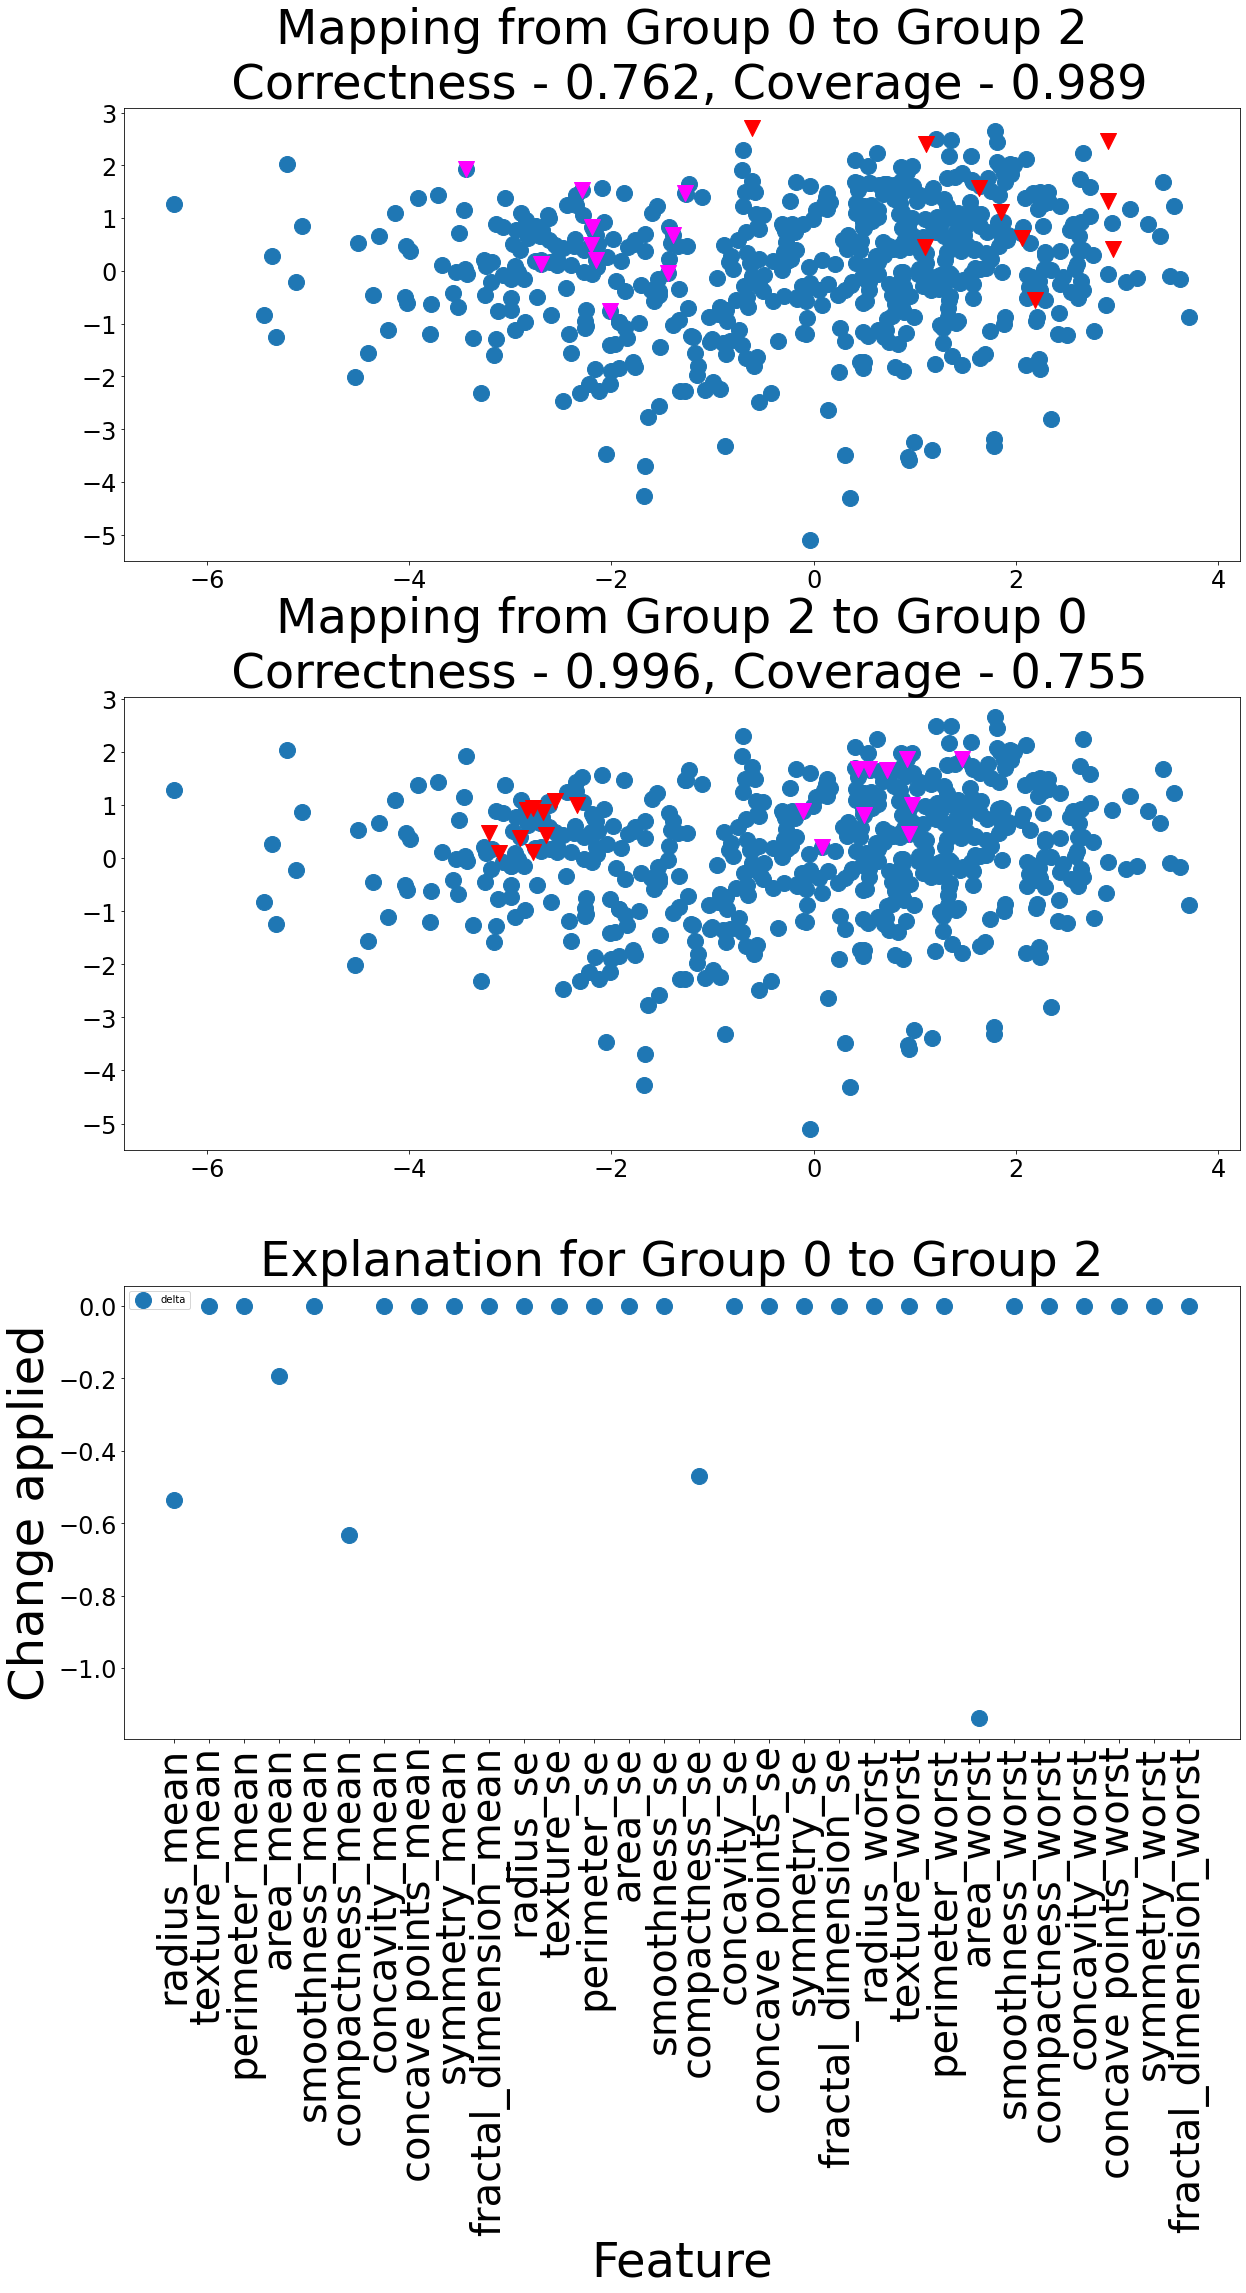

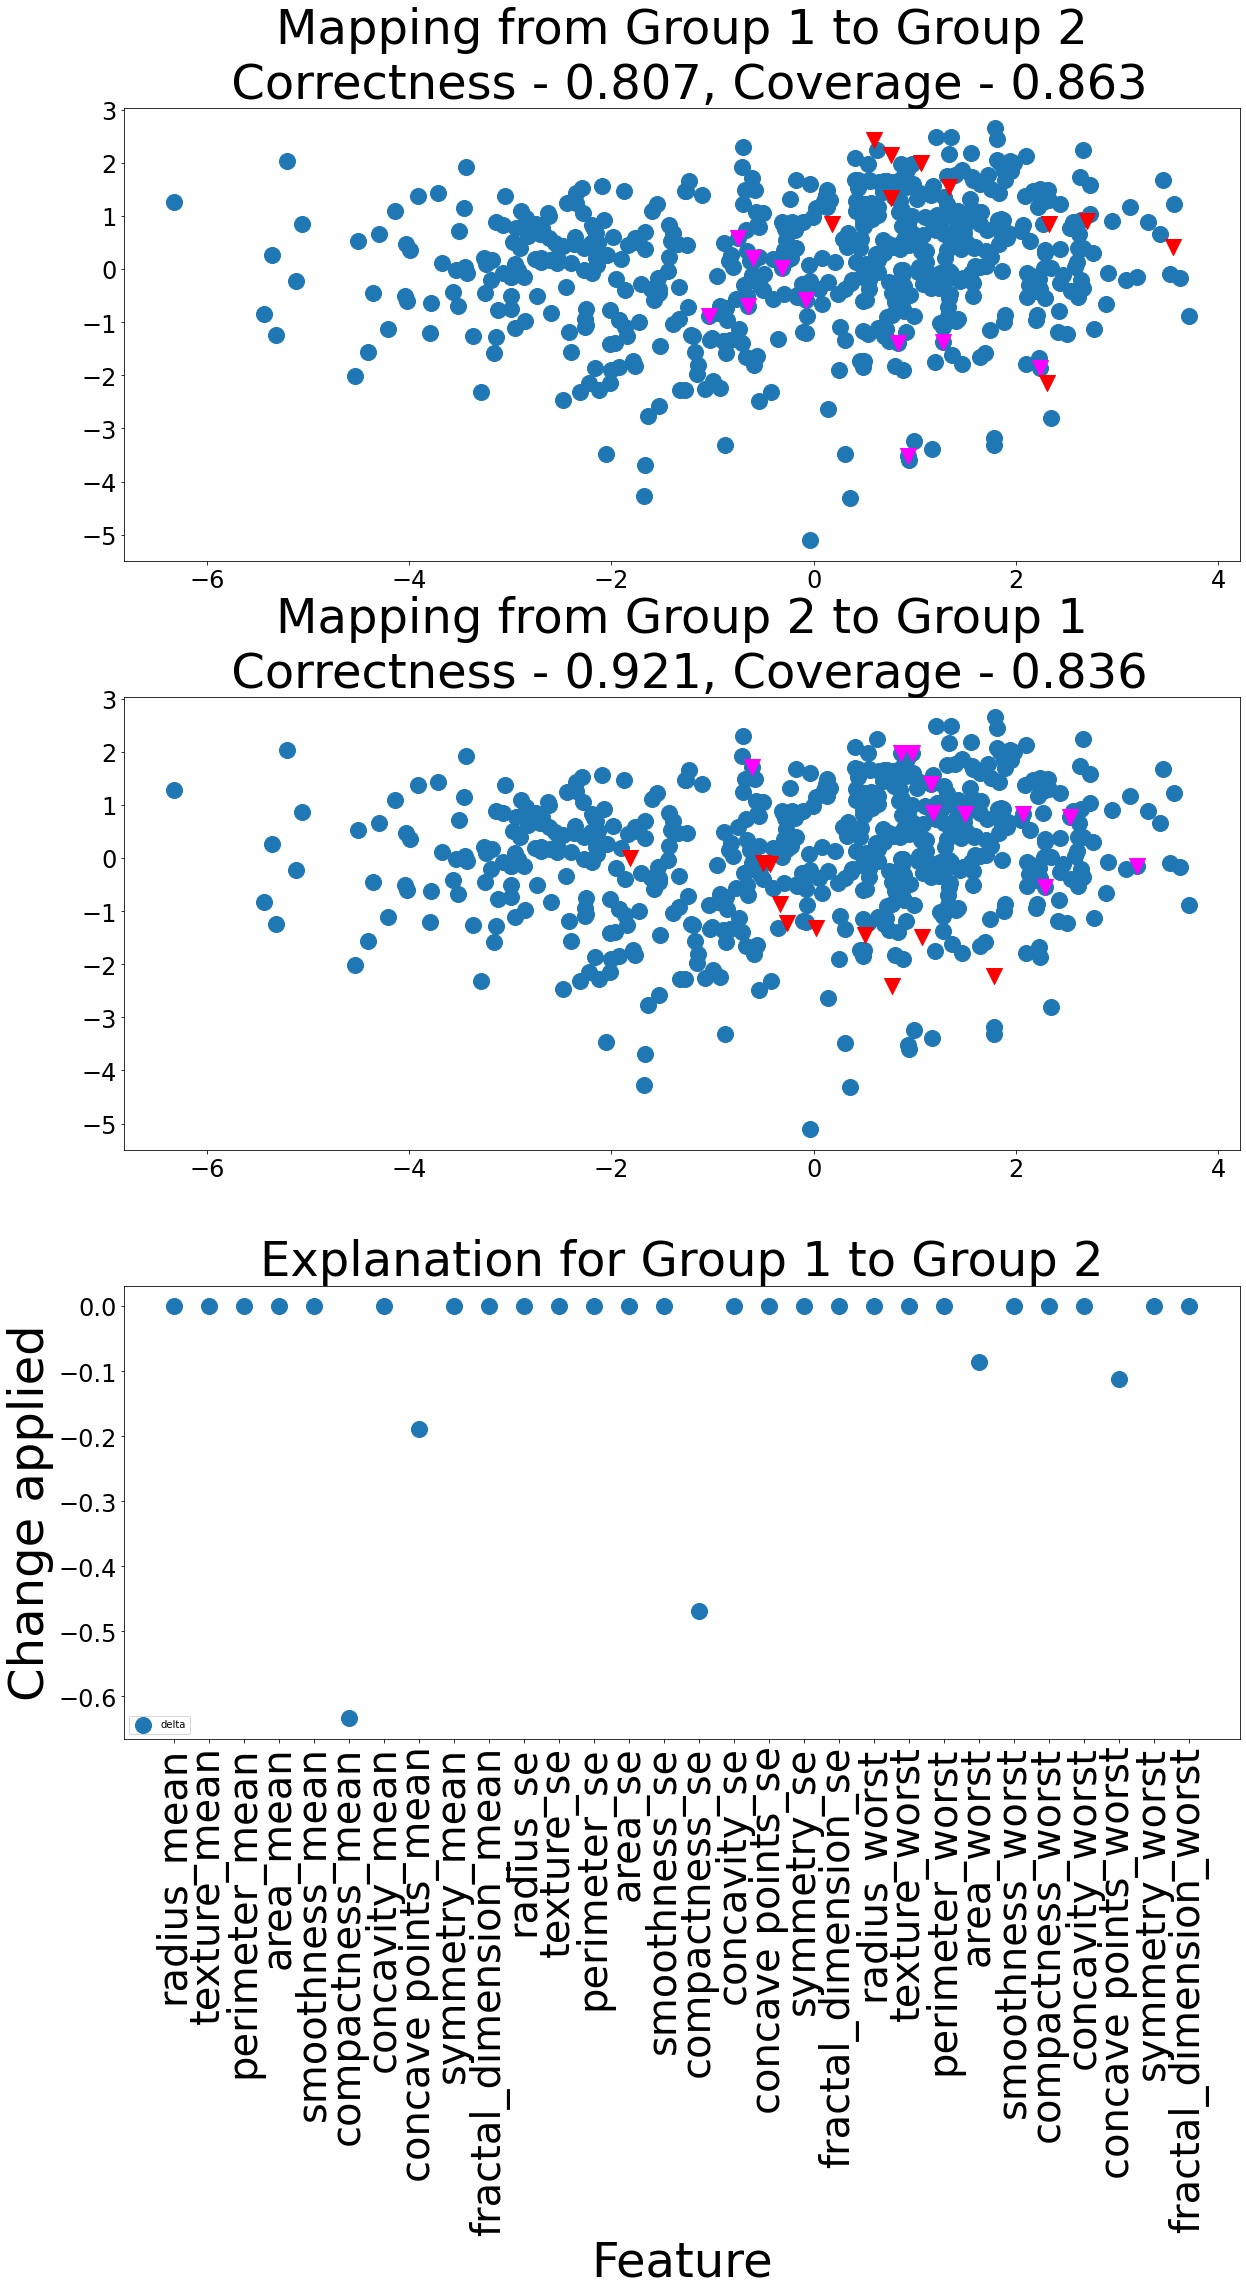

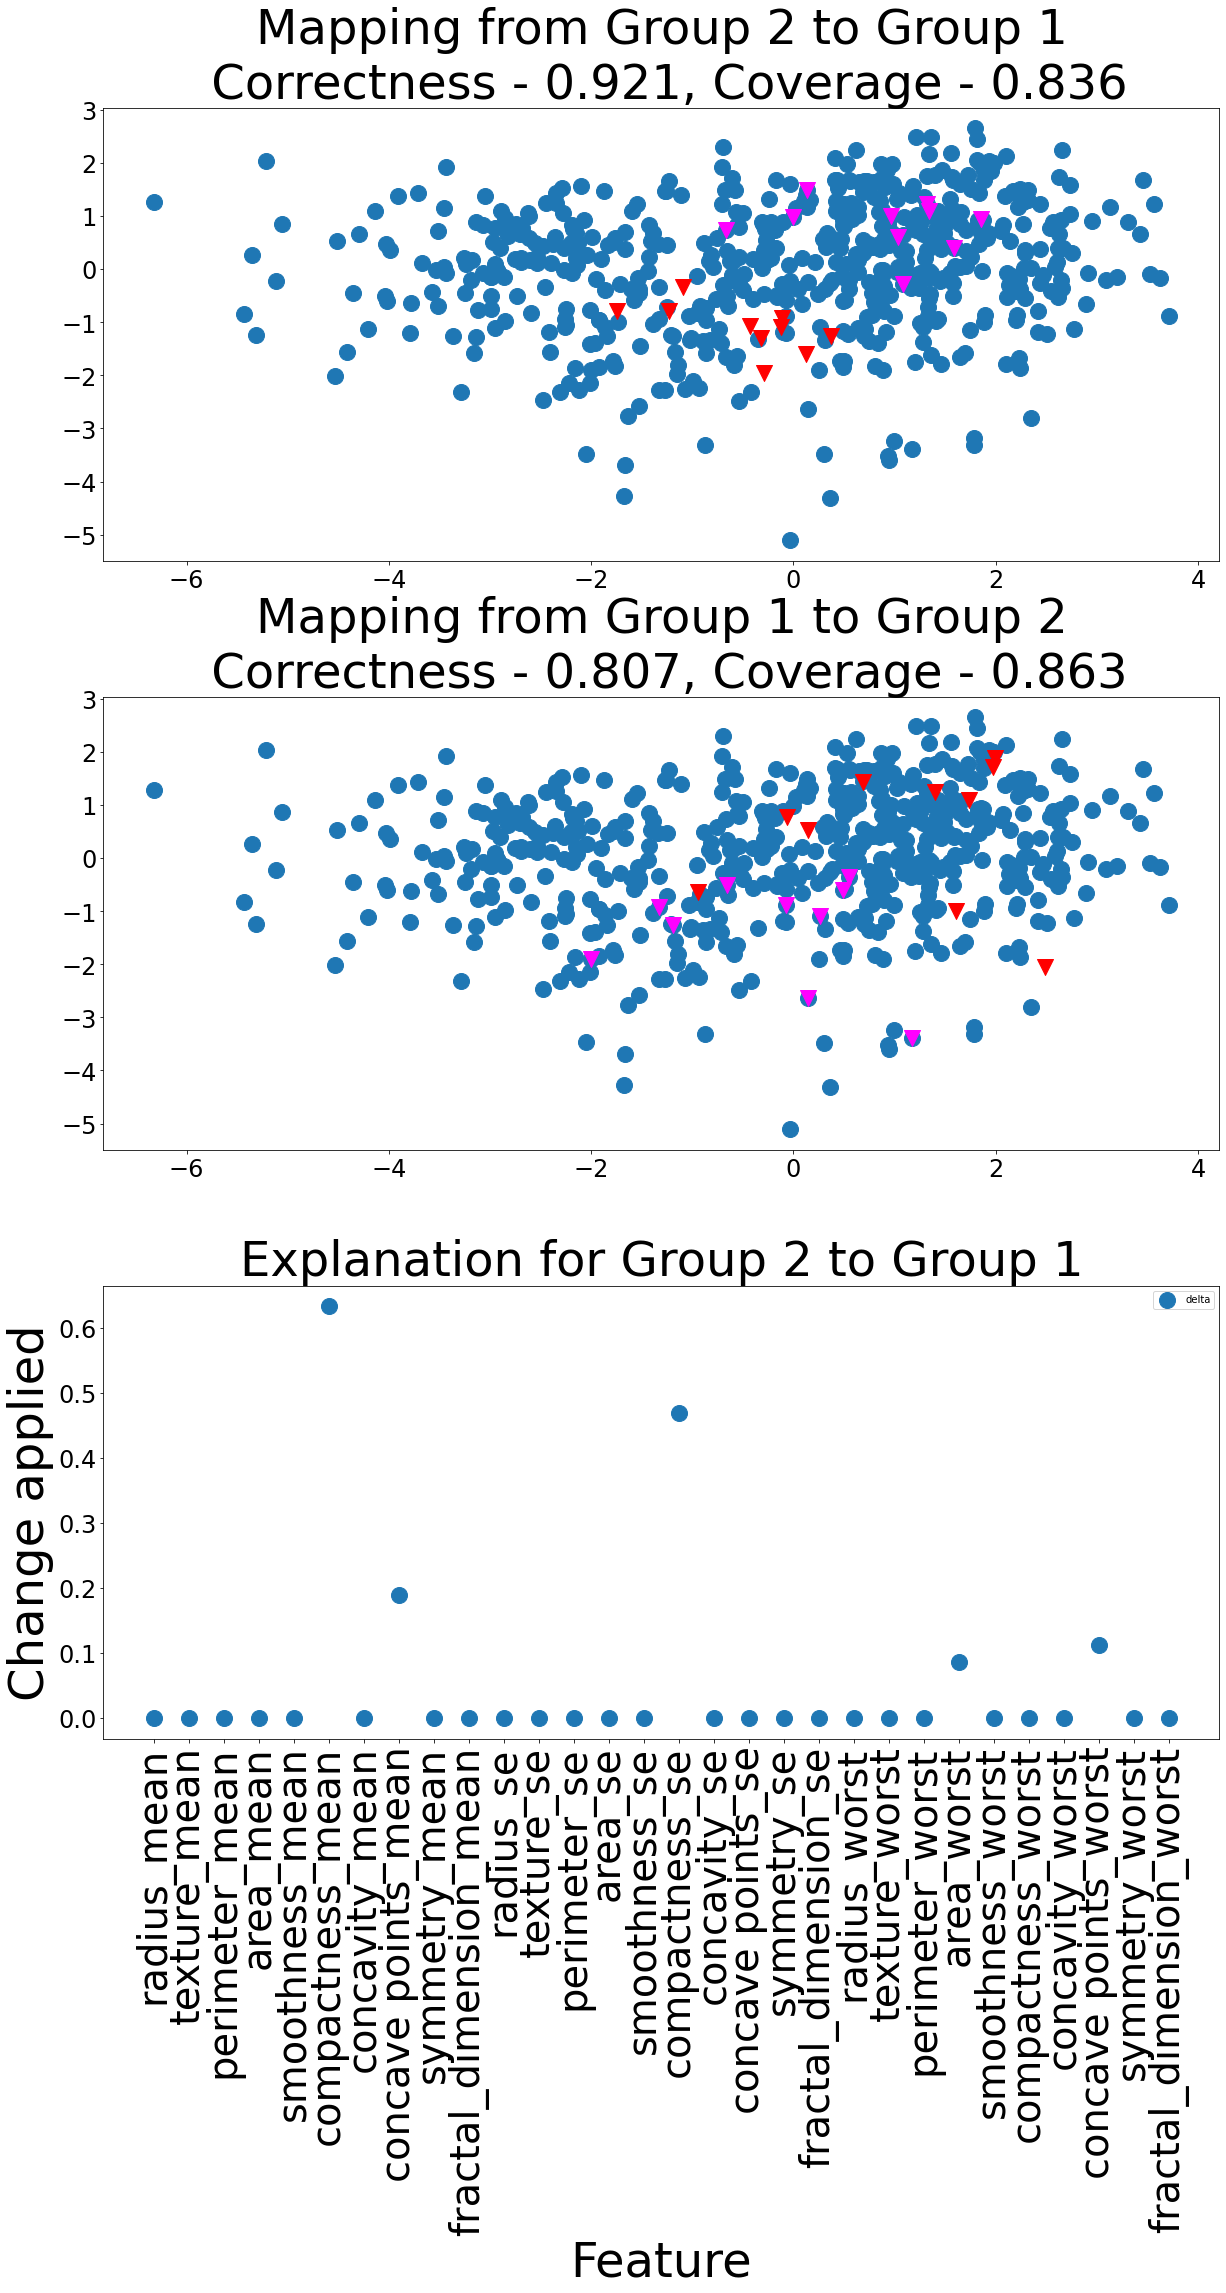

In [12]:
# Evaluate the explanations
from eldr.explain.explain_cs import *
from eldr.plotter.myplot import *
k = 5
import torch
deltas_ = np.load("./deltas/deltas" + str(k) + ".npy")
np.set_printoptions(suppress=True)
print(deltas_)

Explainer = Explain(model, means, centers)

a, b = Explainer.metrics(torch.tensor(x), indices, torch.from_numpy(deltas_), epsilon, k = k)

plot_metrics(a, b, name = "breast-metrics.png")

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 1, k = k, num_points = 10, name = "breast-0to1.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 1, 0, k = k,  num_points = 10, name = "breast-1to0.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 2, k = k, num_points = 10, name = "breast-0to2.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 1, 2, k = k,  num_points = 10, name = "breast-1to2.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 2, 1, k = k,  num_points = 10, name = "breast-2to1.png", feature_names = feature_names)

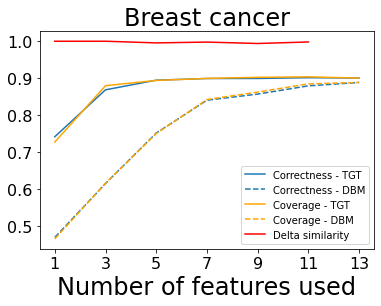

In [13]:
from eldr.misc import load
import matplotlib
matplotlib.rc("xtick", labelsize = 16)
matplotlib.rc("ytick", labelsize = 16)
matplotlib.rc("axes", titlesize = 24)
matplotlib.rc("axes", labelsize = 24)

K = [1, 3, 5, 7, 9, 11, 13]


out_path = './out.csv'
out = np.loadtxt(out_path, delimiter=",")
S_deltas = np.zeros(len(K) - 1)
S_range = []
for c in range(len(K) - 1):
    k_more = K[c]
    k_less = K[c + 1]
    
    d_more = np.load("./deltas/deltas" + str(k_more) + ".npy")
    d_less = np.load("./deltas/deltas" + str(k_less) + ".npy")
    
    res_deltas = np.ones((num_clusters, num_clusters))
    res_gammas = np.ones((num_clusters, num_clusters))
    
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                e_d_more = load(d_more, k_more, i, j).numpy()
                e_d_less = load(d_less, k_less, i, j).numpy()
                
                res_deltas[i,j] = Explainer.similarity(e_d_more, e_d_less)
    S_deltas[c] = np.mean(res_deltas)
    S_range.append(k_more)
    
plt.plot(out[:, 0], out[:, 1], c = "C0", label = "Correctness - TGT")
plt.plot(out[:, 0], out[:, 3], ls = "--", c= "C0", label = "Correctness - DBM")
plt.plot(out[:, 0], out[:, 2], c = "orange", label = "Coverage - TGT")
plt.plot(out[:, 0], out[:, 4], ls = "--", color = "orange", label = "Coverage - DBM")
plt.plot(S_range, S_deltas, c = 'red', label='Delta similarity')
plt.xlabel('Number of features used')
plt.title('Breast cancer')
plt.xticks(np.arange(1, 15, step=2))
plt.legend()

plt.savefig("breast-tradeoff.png", bbox_inches='tight')
plt.show()
plt.close()

### Classification

In [23]:
class_data = []
class_label = []
for i, ind in enumerate(indices):
    class_data.extend(x[ind])
    class_label.extend([i]*len(ind))

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import LinearSVC
X = class_data
y = class_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=0)
clf = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)

In [25]:
estimators = clf.estimators_

In [26]:
from sklearn.inspection import permutation_importance
imp = []
for i, clf in enumerate(estimators):
    results = permutation_importance(clf, X, y, scoring='accuracy')
    importance = results.importances_mean
    imp.append(importance)

In [27]:
df = pd.DataFrame(imp, columns = feature_names, dtype = float)
df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.003873,-0.003169,0.004577,0.004577,-0.002113,-0.002817,0.015845,0.020070,-0.002113,0.003873,...,0.020070,-0.001761,0.012324,0.009859,-0.003521,-0.002817,0.008451,0.005986,0.002113,-0.002113
1,-0.002817,-0.001056,-0.002817,-0.001408,-0.001761,-0.008803,-0.014789,-0.007746,0.001761,-0.000352,...,-0.001408,-0.004577,-0.003169,0.000000,-0.004225,-0.009859,-0.013028,-0.016549,-0.000704,-0.000704
2,-0.002817,0.000352,0.000000,0.000000,-0.000352,-0.014789,-0.001408,0.002465,-0.000704,-0.014789,...,-0.003169,0.000352,0.000352,-0.000704,-0.001056,-0.007394,-0.001761,0.000352,-0.001056,-0.001761


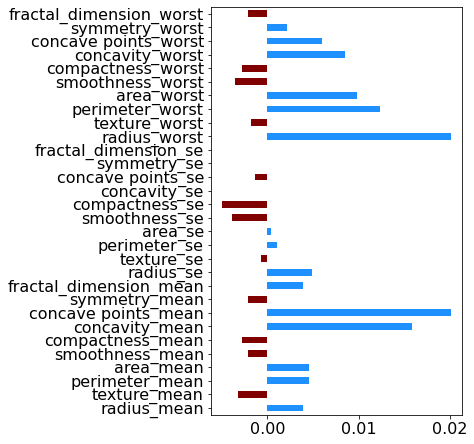

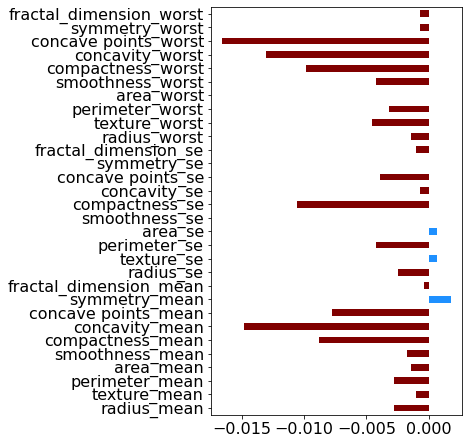

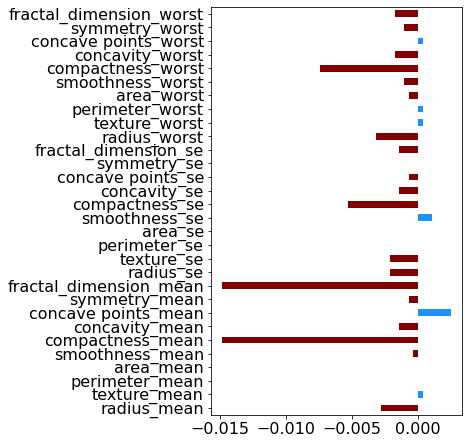

In [28]:
for i in range(len(df)):
    fig = plt.figure(figsize=(4.5,7.5))
    color = (df.iloc[i] > 0).apply(lambda x: 'dodgerblue' if x else 'maroon')
    df.iloc[i].plot.barh(color=color)
    plt.show()